Hi, this toy example is inspired by Codecademy: INTRO TO PYTORCH AND NEURAL NETWORKS
https://www.codecademy.com/enrolled/courses/intro-to-py-torch-and-neural-networks



In [49]:
import pandas as pd 
import torch as torch
import sklearn as sk
import numpy as np

In [50]:
df = pd.read_csv('streeteasy.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_id         5000 non-null   int64  
 1   building_id       5000 non-null   int64  
 2   rent              5000 non-null   int64  
 3   bedrooms          5000 non-null   float64
 4   bathrooms         5000 non-null   int64  
 5   size_sqft         5000 non-null   int64  
 6   min_to_subway     5000 non-null   int64  
 7   floor             5000 non-null   float64
 8   building_age_yrs  5000 non-null   int64  
 9   no_fee            5000 non-null   int64  
 10  has_roofdeck      5000 non-null   int64  
 11  has_washer_dryer  5000 non-null   int64  
 12  has_doorman       5000 non-null   int64  
 13  has_elevator      5000 non-null   int64  
 14  has_dishwasher    5000 non-null   int64  
 15  has_patio         5000 non-null   int64  
 16  has_gym           5000 non-null   int64  


,rental_id,building_id,rent,bedrooms,bathrooms,size_sqft,min_to_subway,floor,building_age_yrs,no_fee,has_roofdeck,has_washer_dryer,has_doorman,has_elevator,has_dishwasher,has_patio,has_gym,neighborhood,submarket,borough
0,1545,44518357,2550,0.0,1,480,9,2.0,17,1,1,0,0,1,1,0,1,Upper East Side,All Upper East Side,Manhattan
1,2472,94441623,11500,2.0,2,2000,4,1.0,96,0,0,0,0,0,0,0,0,Greenwich Village,All Downtown,Manhattan
2,10234,87632265,3000,3.0,1,1000,4,1.0,106,0,0,0,0,0,0,0,0,Astoria,Northwest Queens,Queens
3,2919,76909719,4500,1.0,1,916,2,51.0,29,0,1,0,1,1,1,0,0,Midtown,All Midtown,Manhattan
4,2790,92953520,4795,1.0,1,975,3,8.0,31,0,0,0,1,1,1,0,1,Greenwich Village,All Downtown,Manhattan


In [51]:
## extracting target values
y_pre = torch.tensor(df['rent'].values, dtype=torch.float32)

In [52]:
from sklearn.preprocessing import StandardScaler

y_scaler = StandardScaler()

y_numpy = y_pre.numpy().reshape(-1,1)

y_scaled = y_scaler.fit_transform(y_numpy)

y = torch.tensor(y_scaled, dtype=torch.float32).flatten()

In [53]:
## extracting the important features
imp_features = ['bedrooms', 'bathrooms', 'size_sqft', 'min_to_subway', 'floor', 'building_age_yrs', 'has_elevator', 'has_dishwasher', 'has_gym']
X_pre = torch.tensor(df[imp_features].values, dtype=torch.float32)

In [54]:
## normalize features to improve training speed and stability
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pre)
X = torch.tensor(X_scaled, dtype= torch.float32)


In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
## build a simple model 
import torch.nn as nn 

model = nn.Sequential(
    nn.Linear(len(imp_features), 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 1)
)

loss_fn = nn.MSELoss()


In [57]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5 )

In [58]:
# add a learning rate scheduler (proposed by claude.ai)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode = 'min', factor=0.5, patience=50, verbose=True)

/opt/anaconda3/envs/timeseries/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [59]:
## training loop 


train_losses = []
eval_losses = []

#early stopping mechanism (proposed by claude.ai)
patience = 100
best_val_loss = float('inf')
counter = 0

num_epochs = 1000
for epoch in range(num_epochs):
    
    model.train()
    predictions = model(X_train).squeeze()
    train_loss = loss_fn(predictions, y_train)

    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad()


    model.eval()
    with torch.no_grad():
        eval_predictions = model(X_test).squeeze()
        eval_loss = loss_fn(eval_predictions, y_test)

    
    scheduler.step(eval_loss)
    

    train_losses.append(train_loss.item())
    eval_losses.append(eval_loss.item())

    if (epoch + 1)% 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss.item():.2f}, Val Loss: {eval_loss.item():.2f}')


    if eval_loss < best_val_loss:
        best_val_loss = eval_loss
        counter = 0

        torch.save(model.state_dict(), 'best_model.pt')
    else:
        counter  += 1
        if counter >= patience:
            print(f'early stopping in epoch {epoch + 1}')
            break


    

Epoch [100/1000], Train Loss: 0.42, Val Loss: 0.46
Epoch [200/1000], Train Loss: 0.26, Val Loss: 0.29
Epoch [300/1000], Train Loss: 0.24, Val Loss: 0.27
Epoch [400/1000], Train Loss: 0.23, Val Loss: 0.26
Epoch [500/1000], Train Loss: 0.22, Val Loss: 0.25
Epoch [600/1000], Train Loss: 0.22, Val Loss: 0.25
Epoch [700/1000], Train Loss: 0.21, Val Loss: 0.25
Epoch [800/1000], Train Loss: 0.21, Val Loss: 0.25
Epoch [900/1000], Train Loss: 0.21, Val Loss: 0.24
Epoch [1000/1000], Train Loss: 0.20, Val Loss: 0.24


In [62]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()


with torch.no_grad():
    test_predictions = model(X_test)
    test_loss = loss_fn(test_predictions, y_test)

    # Calculate R² score
    y_mean = y_test.mean()
    ss_tot = ((y_test - y_mean) ** 2).sum()
    ss_res = ((y_test - test_predictions) ** 2).sum()
    r2 = 1 - (ss_res / ss_tot)
    
    print(f"Test MSE: {test_loss.item():.2f}")
    print(f"R² Score: {r2.item():.4f}")

Test MSE: 1.94
R² Score: -1792.5734


/var/folders/fl/v92s5yms06xcc1c654z7q5fh0000gn/T/ipykernel_20883/3154875118.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.

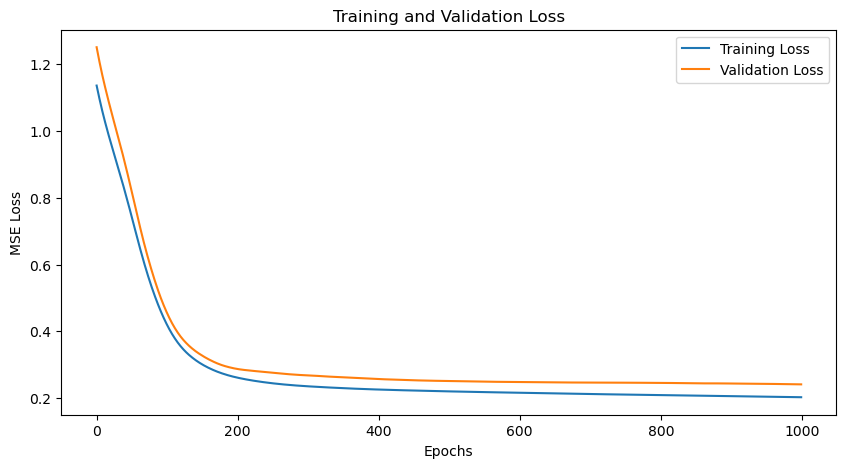

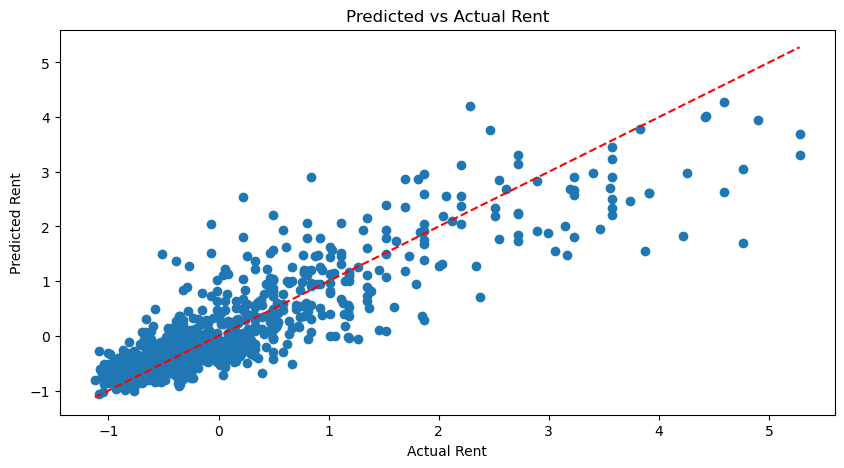

In [61]:
## visualaization (100% generated by claude.ai)

import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(eval_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot predictions vs actual
plt.figure(figsize=(10, 5))
plt.scatter(y_test.numpy(), test_predictions.numpy())
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.title('Predicted vs Actual Rent')
plt.show()
